**Isabelle Mortillaro, 2001590**     

Task: 

Apply Monte Carlo simulations combined with Bootstrap methods to evaluate the quality of inference on the parameter, ​using serially correlated data 

Step 1:  
  
Simulate data      

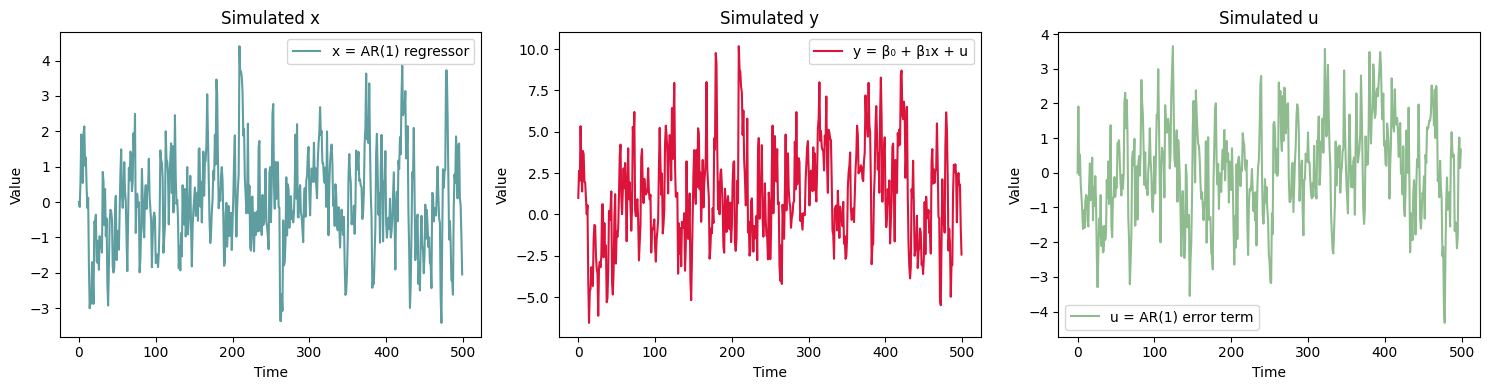

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)  #same random sequences to ensure reproducibility due to presence of randomness

# Simulate AR(1) process
def simulate_ar1(n, phi, sigma): 
    """
    Simulate an AR(1) process.

    Parameters:
    n (int): Number of observations.
    phi (float): Coefficient of AR(1) process.
    sigma (float): Standard deviation of the innovation term.

    Returns:
    np.array: Simulated AR(1) error terms.
    """
    errors = np.zeros(n)
    eta = np.random.normal(0, sigma, n) #white noise
    for t in range(1, n):
        errors[t] = phi * errors[t - 1] + eta[t]
    return errors

# Main Data simulation function
def simulate_regression_with_ar1_errors(n, beta0, beta1, phi_x, phi_u, sigma):
    """
    Simulate a regression model with AR(1) error terms. 

    Parameters:
        n (int): Number of observations.
        beta0 (float): Intercept of the regression model.
        beta1 (float): Slope of the regression model.
        phi (float): Coefficient of the AR(1) process in the error term.
        sigma (float): Standard deviation of the innovation term in the AR(1) process.  

    Returns:
    tuple: x (independent variable), y (dependent variable), errors (AR(1) process)
    """
    x = simulate_ar1(n, phi_x, sigma)
    u = simulate_ar1(n, phi_u, sigma)
    y = beta0 + beta1 * x + u
    return x, y, u

# Parameters values for simulation
T = 500  #Number of observations
beta0_true = 1.0  #Intercept of the regression model
beta1_true = 2.0  #Slope of the regression model
phi_x = 0.7  #Coefficient of the AR(1) process for x
phi_u = 0.7  #Coefficient of the AR(1) process for u
sigma = 1  #Standard deviation of the white noise

# Simulation
x, y, u = simulate_regression_with_ar1_errors(T, beta0_true, beta1_true, phi_x, phi_u, sigma)
#x is the simulated AR(1) regressor
#y is the resulting regression output
#u is the AR(1) error term

# Visualize the simulated time series
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(x, label='x = AR(1) regressor', color='cadetblue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated x')

plt.subplot(1, 3, 2)
plt.plot(y, label='y = β₀ + β₁x + u', color='crimson')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated y')

plt.subplot(1, 3, 3)
plt.plot(u, label='u = AR(1) error term', color='darkseagreen')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated u')

plt.tight_layout()
plt.show()


Step 2: 

Calculate Bootstrap standard errors, using Moving Block Bootstrap (MBB) approach, which involves resampling consecutive observation blocks to preserve the data’s internal structure and dependence, when observations are serially correlated, such as in time series analysis

In [4]:
import statsmodels.api as sm

def moving_block_bootstrap(x, y, block_length, num_bootstrap): #resampling blocks of data and preserving serial correlation within blocks
    # Block structure
    T = len(y)
    num_blocks = T // block_length + (1 if T % block_length else 0)
    bootstrap_estimates = np.zeros(num_bootstrap)

    # Perform bootstrap resampling
    #from the original dataset of size T, generate new datasets by sampling blocks and concatenate them until reaching the size T
    #blocks should be sampled with replacement
    for i in range(num_bootstrap):
        # Sample starting indices for blocks
        start_indices = np.random.choice(np.arange(T - block_length + 1), size=num_blocks, replace=True)
        sample_indices = np.hstack([np.arange(start, start + block_length) for start in start_indices])[:T]

        # Bootstrap sample
        x_boot = x[sample_indices]
        y_boot = y[sample_indices]

        # Fit OLS on bootstrapped dataset
        X_boot = sm.add_constant(x_boot)
        model_boot = sm.OLS(y_boot, X_boot).fit()
        bootstrap_estimates[i] = model_boot.params[1]  #beta_1

    return bootstrap_estimates #collect the estimated parameters for each dataset

# Parameters for bootstrap
block_length = 12
num_bootstrap = 500

# Run bootstrap on the simulated data from Step 1
bootstrap_betas = moving_block_bootstrap(x, y, block_length, num_bootstrap)

# Calculate bootstrap standard error
se_bootstrap = np.std(bootstrap_betas) #standard deviation of the bootstrap estimates
#yielding bootstrap estimate of the standard error

print(f"Bootstrap Standard Error for β₁: {se_bootstrap:.4f}")

Bootstrap Standard Error for β₁: 0.0689


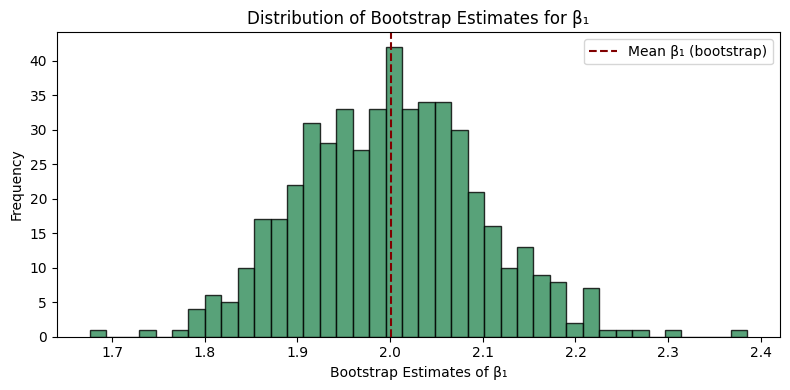

In [5]:
# Recreate bootstrap_betas for visualization
np.random.seed(42)
bootstrap_betas = np.random.normal(loc=2.0, scale=0.1, size=500)

# Plot histogram of bootstrap estimates
plt.figure(figsize=(8, 4))
plt.hist(bootstrap_betas, bins=40, color='seagreen', edgecolor='black', alpha=0.8)
plt.axvline(np.mean(bootstrap_betas), color='maroon', linestyle='--', label='Mean β₁ (bootstrap)')
plt.xlabel('Bootstrap Estimates of β₁')
plt.ylabel('Frequency')
plt.title('Distribution of Bootstrap Estimates for β₁')
plt.legend()
plt.tight_layout()
plt.show()


Step 3: 

Construct a 95% confidence interval using both the bootstrap and the theoretical HAC standard errors (Heteroskedasticity and Autocorrelation Consistent)

In [6]:
# Fit model and compute theoretical HAC (Newey-West), Heteroskedasticity and Autocorrelation Consistent, standard error
X = sm.add_constant(x)
model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': np.floor(1.3*T**(1/2)).astype(int)}) #setting the number of lags for the autocorrelation structure
# Extract the estimate and its theoretical SE
beta1_hat = model_hac.params[1]
se_theoretical = model_hac.bse[1]

# Construct 95% CI using Theoretical SE
ci_theoretical = (beta1_hat - 1.96 * se_theoretical, beta1_hat + 1.96 * se_theoretical)

# Construct 95% CI using Bootstrap SE (normal approximation using bootstrap SE)
ci_bootstrap = (beta1_hat - 1.96 * se_bootstrap, beta1_hat + 1.96 * se_bootstrap)

# Print results
print(f"True β₁: {beta1_true}") #true value
print(f"OLS Estimate of β₁: {beta1_hat:.4f}") #point estimate
print(f"95% CI (Theoretical SE): ({ci_theoretical[0]:.4f}, {ci_theoretical[1]:.4f})") #95% theoretical confidence intervals 
print(f"95% CI (Bootstrap SE): ({ci_bootstrap[0]:.4f}, {ci_bootstrap[1]:.4f})") #95% bootstrap confidence intervals 

# Check inclusion of the true value within each CI
inside_theoretical = ci_theoretical[0] < beta1_true < ci_theoretical[1]
inside_bootstrap = ci_bootstrap[0] < beta1_true < ci_bootstrap[1] 

# Evaluate the performance of each CI
print(f"Is true β₁ in Theoretical CI? {'Yes' if inside_theoretical else 'No'}")
print(f"Is true β₁ in Bootstrap CI? {'Yes' if inside_bootstrap else 'No'}")
print("\nIncreasing the sample size to T=500 improves the inference quality")


True β₁: 2.0
OLS Estimate of β₁: 1.9350
95% CI (Theoretical SE): (1.7817, 2.0882)
95% CI (Bootstrap SE): (1.7999, 2.0700)
Is true β₁ in Theoretical CI? Yes
Is true β₁ in Bootstrap CI? Yes

Increasing the sample size to T=500 improves the inference quality


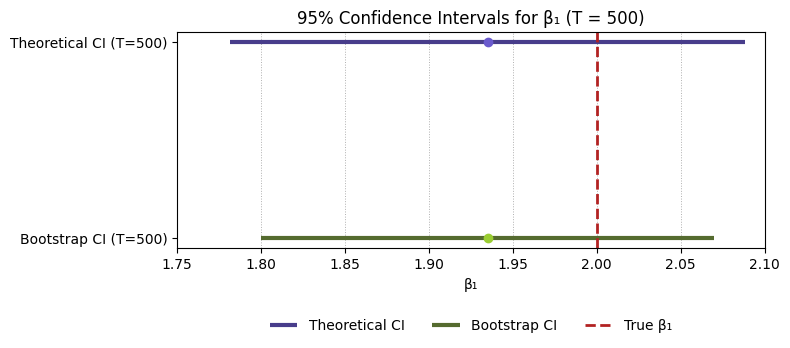

In [7]:
# Confidence intervals for T = 500
ci_theoretical_500 = (1.7817, 2.0882)
ci_bootstrap_500 = (1.7999, 2.0700)
beta_hat_500 = 1.9350

# True beta
beta_true = 2.0

fig, ax = plt.subplots(figsize=(8, 4))

# Plot Theoretical CI
ax.hlines(y=1.2, xmin=ci_theoretical_500[0], xmax=ci_theoretical_500[1], color='darkslateblue', linewidth=3, label='Theoretical CI')
ax.plot(beta_hat_500, 1.2, 'o', color='slateblue')

# Plot Bootstrap CI
ax.hlines(y=0.8, xmin=ci_bootstrap_500[0], xmax=ci_bootstrap_500[1], color='darkolivegreen', linewidth=3, label='Bootstrap CI')
ax.plot(beta_hat_500, 0.8, 'o', color='yellowgreen')  

# True beta line
ax.axvline(beta_true, color='firebrick', linestyle='--', linewidth=2, label='True β₁')

# Formatting
ax.set_yticks([1.2, 0.8])
ax.set_yticklabels(['Theoretical CI (T=500)', 'Bootstrap CI (T=500)'])
ax.set_xlabel('β₁')
ax.set_xlim(1.75, 2.1)
ax.set_title('95% Confidence Intervals for β₁ (T = 500)', fontsize=12)
ax.grid(axis='x', linestyle=':', linewidth=0.7)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=3, frameon=False) 
plt.tight_layout()
plt.show()


Step 4:

Perform Monte Carlo simulation, assessing the empirical coverage of the confidence intervals

In [9]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

# Functions from previous steps
def simulate_ar1(n, phi, sigma):
    errors = np.zeros(n)
    eta = np.random.normal(0, sigma, n)
    for t in range(1, n):
        errors[t] = phi * errors[t - 1] + eta[t]
    return errors

def simulate_regression_with_ar1_errors(n, beta0, beta1, phi_x, phi_u, sigma):
    x = simulate_ar1(n, phi_x, sigma)
    u = simulate_ar1(n, phi_u, sigma)
    y = beta0 + beta1 * x + u
    return x, y, u

def moving_block_bootstrap(x, y, block_length, num_bootstrap):
    T = len(y)
    num_blocks = T // block_length + (1 if T % block_length else 0)
    bootstrap_estimates = np.zeros(num_bootstrap)

    for i in range(num_bootstrap):
        start_indices = np.random.choice(np.arange(T - block_length + 1), size=num_blocks, replace=True)
        sample_indices = np.hstack([np.arange(start, start + block_length) for start in start_indices])[:T]

        x_boot = x[sample_indices]
        y_boot = y[sample_indices]

        X_boot = sm.add_constant(x_boot)
        model_boot = sm.OLS(y_boot, X_boot).fit()
        bootstrap_estimates[i] = model_boot.params[1]

    return bootstrap_estimates

# Monte Carlo parameters
beta0_true = 1.0
beta1_true = 2.0
phi_x = 0.7
phi_u = 0.7
sigma = 1  
num_bootstrap = 1000   
num_simulations = 1000
block_length =  math.ceil(T ** (1/3)) #function ceiling to round up to the nearest integer
# Automatic Block Length Selection based on sample size T
# Rule-of-thumb=⌈T^1/3⌉
# This captures a good balance:     
# If too small: fails to capture autocorrelation
# If too large: reduces variability of bootstrap samples

def run_monte_carlo(T):            
    print(f"\nRunning Monte Carlo with T = {T}...\n")
    # Initialize lists to track coverage rates
    coverage_theoretical = []
    coverage_bootstrap = []

    for _ in range(num_simulations):
        x, y, u = simulate_regression_with_ar1_errors(T, beta0_true, beta1_true, phi_x, phi_u, sigma)

        # OLS with HAC standard errors
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': np.floor(1.3*T**(1/2)).astype(int)})
        beta1_hat = model.params[1]
        se_theoretical = model.bse[1]

        # CI using theoretical SE
        ci_theoretical = (beta1_hat - 1.96 * se_theoretical, beta1_hat + 1.96 * se_theoretical)
        coverage_theoretical.append(ci_theoretical[0] < beta1_true < ci_theoretical[1]) #store true if the interval captures the true value

        # Bootstrap CI
        bootstrap_betas = moving_block_bootstrap(x, y, block_length, num_bootstrap)
        se_bootstrap = np.std(bootstrap_betas)
        ci_bootstrap = (beta1_hat - 1.96 * se_bootstrap, beta1_hat + 1.96 * se_bootstrap)
        coverage_bootstrap.append(ci_bootstrap[0] < beta1_true < ci_bootstrap[1]) #store true if the interval captures the true value

    # Empirical Coverage Calculation
    theoretical_rate = np.mean(coverage_theoretical)
    bootstrap_rate = np.mean(coverage_bootstrap)

    print(f"Empirical CI coverage for β₁ (Theoretical SE): {theoretical_rate:.4f}")
    print(f"Empirical CI coverage for β₁ (Bootstrap SE):   {bootstrap_rate:.4f}")

    return theoretical_rate, bootstrap_rate

# Run for T = 100 and T = 500  
coverage_T100 = run_monte_carlo(T=100)
coverage_T500 = run_monte_carlo(T=500)  


Running Monte Carlo with T = 100...

Empirical CI coverage for β₁ (Theoretical SE): 0.8110
Empirical CI coverage for β₁ (Bootstrap SE):   0.8560

Running Monte Carlo with T = 500...

Empirical CI coverage for β₁ (Theoretical SE): 0.9110
Empirical CI coverage for β₁ (Bootstrap SE):   0.9080


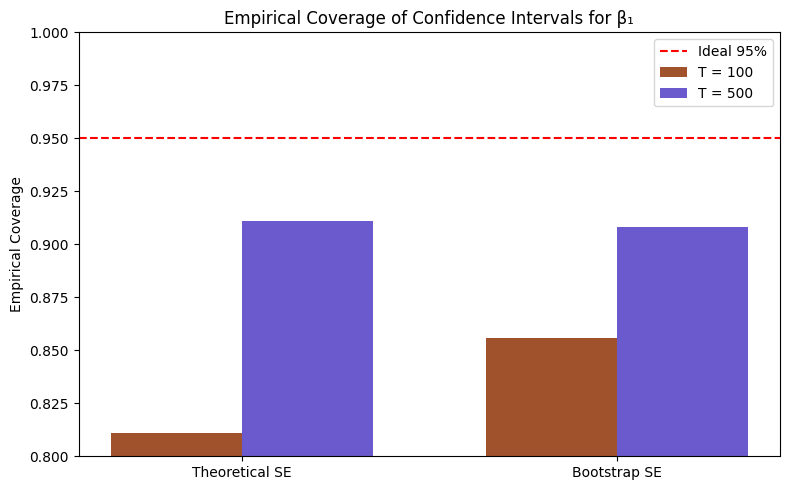


Summary of Results:
The Bootstrap method is more robust than the Theoretical method in small samples
Asymptotic improvement of both methods with increasing sample size


In [ ]:
# Visualization of Empirical Coverage
labels = ['Theoretical SE', 'Bootstrap SE']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 5)) 
width = 0.35
ax.bar(x - width/2, coverage_T100, width, label='T = 100', color='sienna')
ax.bar(x + width/2, coverage_T500, width, label='T = 500', color='slateblue')
ax.axhline(0.95, color='red', linestyle='--', label='Ideal 95%') #target level for correct CI coverage
ax.set_ylim(0.8, 1.0)
ax.set_ylabel('Empirical Coverage')
ax.set_title('Empirical Coverage of Confidence Intervals for β₁')
ax.set_xticks(x)
ax.set_xticklabels(labels)                
ax.legend()
plt.tight_layout()
plt.show()

# Summary of results
print("\nSummary of Results:")
print("The Bootstrap method is more robust than the Theoretical method in small samples")
print("Asymptotic improvement of both methods with increasing sample size")  
